## Wu-Yang Method for KS Inversion
Please check the original paper of the Wu-Yang method: [Qin Wu, Weitao Yang, J. Chem. Phys. 118, 2498 (2003)](https://aip.scitation.org/doi/abs/10.1063/1.1535422?casa_token=caPxLNp1Jm8AAAAA:WsOECHVnX79_uiv6Gxx7DcxXcQ2QTl-_wRKNVekhXK9gIvVZ22T2oFk9_hya4Tc8C7iixmki3YceYA).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import gto

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

---
### Perform target calculation with Psi4. 
Store wavefunction (wfn) object

In [2]:
# Define Molecule
mol = gto.M(atom = """
                  Be
                  """,
basis = 'aug-cc-pvtz')

# Perform Calculation
mf = mol.KS()
mf.xc = 'scan'
mf.kernel()

# Extract data for n2v. 
da, db = mf.make_rdm1()/2, mf.make_rdm1()/2
ca, cb = mf.mo_coeff[:,:mol.nelec[0]], mf.mo_coeff[:, :mol.nelec[1]]
ea, eb = mf.mo_energy, mf.mo_energy

# Initialize inverter object. 
inv = n2v.Inverter( engine='pyscf' )

inv.set_system( mol, 'aug-cc-pvtz', pbs='aug-cc-pvqz' )
inv.Dt = [da, db]
inv.ct = [ca, cb]
inv.et = [ea, eb]

converged SCF energy = -14.6493195487414
converged SCF energy = -14.4463376075342  <S^2> = -8.8817842e-16  2S+1 = 1


---
### Invert! 
$$v_{Kohn-Sham}=v_{ext}+v_{guide}+v_{PBE}$$
With the guide potential $v_{guide}=v_{Fermi-Amaldi}$ and the rest potential $v_{rest}$ on the potential basis set (pbs) "aug-cc-pvqz".

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.invert("WuYang", guide_components="fermi_amaldi")

Optimization Successful within 2 iterations! |grad|=6.17e-04


/home/vh/miniconda3/envs/n2v/lib/python3.8/site-packages/scipy/optimize/_trustregion.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  p, hits_boundary = m.solve(trust_radius)


---
### Visualization of the potentials. 
#### Since this is a 1-D system, let's first plot it alone x axis.

In [4]:
# Build Grid
inv.eng.grid.build_rectangular((1001,1,1))
x = inv.eng.grid.x

In [5]:
###### Get Hartree and Fermi-Amadli Potentials:

vH = inv.eng.grid.hartree(density=inv.Dt[0]+inv.Dt[1], grid='rectangular')
vFA = (1-1/(inv.nalpha + inv.nbeta)) * vH

---
Fintally, let's find the exchange-correlation potential:
\begin{align}
v_{xc}
&=v_{Kohn-Sham}-v_{Hartree}-v_{ext}\\
&=v_{guide}+v_{rest}-v_{Hartree}
\end{align}

In [8]:
vrest = inv.eng.grid.to_grid(inv.v_pbs, grid='rectangular') 
hartree = inv.eng.grid.hartree(da+db, grid='rectangular')
fa = (1-1/(inv.nalpha + inv.nbeta)) * hartree

# Compute vxc according to the previous equation. 
vxc = vFA + vrest - vH

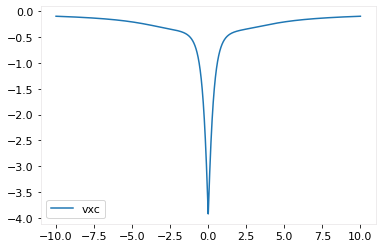

In [9]:
# Plot the potential. 
fig, ax = plt.subplots()
ax.plot(x, vxc, label="vxc")
ax.legend()